<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Meta/blob/master/Demo_Plug_and_Play_with_DRL_Libraries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FinRL-Meta: Plug-and-Play with DRL Libraries
Demostration for plug-and-play with ElegantRL, Stable-baselines3, RLlib

## Part 1: Getting Started - Install Python Packages 

 ### 1.1 Install DRL libraries: FinRL, ElegantRL, RLlib

In [ ]:
## install elegantrl library
!pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git
## install rllib/ray library
!pip install ray[default]
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/ElegantRL.git to /tmp/pip-req-build-2g5mb367
  Running command git clone -q https://github.com/AI4Finance-LLC/ElegantRL.git /tmp/pip-req-build-2g5mb367
     |████████████████████████████████| 89.3 MB 89 kB/s 
     |████████████████████████████████| 448 kB 43.5 MB/s 
  Created wheel for elegantrl: filename=elegantrl-0.3.2-py3-none-any.whl size=89221 sha256=93c929c1a7766785ff04c5801f5c09411eb46d916249a1e13991b0d74bcc1f48
  Stored in directory: /tmp/pip-ephem-wheel-cache-oai6za__/wheels/52/9a/b3/08c8a0b5be22a65da0132538c05e7e961b1253c90d6845e0c6
Successfully built elegantrl
     |████████████████████████████████| 54.7 MB 126 kB/s 
     |████████████████████████████████| 119 kB 57.2 MB/s 
     |████████████████████████████████| 128 kB 71.5 MB/s 
     |████████████████████████████████| 3.0 MB 39.1 MB/s 
     |████████████████████████████████| 82 kB 241 kB/s 
     |████████████████████████████████| 201 kB 52.3 MB/s 
     |██████████████████████████

### 1.2 Check if the additional packages needed are present, if not install them

In [ ]:
# !pip install trading_calendars
# !pip install alpaca_trade_api
# !pip install ccxt
# !pip install jqdatasdk
# !pip install wrds

# !pip install lz4
# !pip install ray[tune]
# !pip install tensorboardX
# !pip install gputil

### 1.3 Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use('Agg')
import datetime

import torch 
import ray
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
#from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent as DRLAgent_sb3
from finrl.drl_agents.rllib.models import DRLAgent as DRLAgent_rllib
from finrl.drl_agents.elegantrl.models import DRLAgent as DRLAgent_erl

from finrl.neo_finrl.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline



/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## Part 2: Train & Test Function

### 2.1 Train

In [ ]:
def train(start_date, end_date, ticker_list, data_source, time_interval, 
          technical_indicator_list, drl_lib, env, model_name, if_vix = True,
          **kwargs):
    
    #fetch data
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)
    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    env_config = {'price_array':price_array,
              'tech_array':tech_array,
              'turbulence_array':turbulence_array,
              'if_train':True}
    env_instance = env(config=env_config)

    #read parameters
    cwd = kwargs.get('cwd','./'+str(model_name))

    if drl_lib == 'elegantrl':
        break_step = kwargs.get('break_step', 1e6)
        erl_params = kwargs.get('erl_params')

        agent = DRLAgent_erl(env = env,
                             price_array = price_array,
                             tech_array=tech_array,
                             turbulence_array=turbulence_array)
        
        model = agent.get_model(model_name, model_kwargs = erl_params)
        trained_model = agent.train_model(model=model, 
                                          cwd=cwd,
                                          total_timesteps=break_step)
      
    elif drl_lib == 'rllib':
        total_episodes = kwargs.get('total_episodes', 100)
        rllib_params = kwargs.get('rllib_params')

        agent_rllib = DRLAgent_rllib(env = env,
                       price_array=price_array,
                       tech_array=tech_array,
                       turbulence_array=turbulence_array)

        model,model_config = agent_rllib.get_model(model_name)

        model_config['lr'] = rllib_params['lr']
        model_config['train_batch_size'] = rllib_params['train_batch_size']
        model_config['gamma'] = rllib_params['gamma']

        #ray.shutdown()
        trained_model = agent_rllib.train_model(model=model, 
                                          model_name=model_name,
                                          model_config=model_config,
                                          total_episodes=total_episodes)
        trained_model.save(cwd)
        
            
    elif drl_lib == 'stable_baselines3':
        total_timesteps = kwargs.get('total_timesteps', 1e6)
        agent_params = kwargs.get('agent_params')

        agent = DRLAgent_sb3(env = env_instance)

        model = agent.get_model(model_name, model_kwargs = agent_params)
        trained_model = agent.train_model(model=model, 
                                tb_log_name=model_name,
                                total_timesteps=total_timesteps)
        print('Training finished!')
        trained_model.save(cwd)
        print('Trained model saved in ' + str(cwd))
    else:
        raise ValueError('DRL library input is NOT supported. Please check.')


### 2.2 Test

In [ ]:
def test(start_date, end_date, ticker_list, data_source, time_interval, 
         technical_indicator_list, drl_lib, env, model_name, if_vix = True,
         **kwargs):
    #fetch data
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)
    
    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':False}
    env_instance = env(config=env_config)

    #load elegantrl needs state dim, action dim and net dim
    net_dimension = kwargs.get('net_dimension', 2**7)
    cwd = kwargs.get('cwd','./'+str(model_name))
    print("price_array: ",len(price_array))

    if drl_lib == 'elegantrl':
        episode_total_assets = DRLAgent_erl.DRL_prediction(model_name=model_name,
                                            cwd=cwd,
                                            net_dimension=net_dimension,
                                            environment=env_instance)

        return episode_total_assets
    
    elif drl_lib == 'rllib':
        #load agent
        episode_total_assets = DRLAgent_rllib.DRL_prediction(
                                  model_name=model_name, 
                                  env = env,
                                  price_array=price_array,
                                  tech_array=tech_array,
                                  turbulence_array=turbulence_array,
                                  agent_path = cwd)

        return episode_total_assets


    elif drl_lib == 'stable_baselines3':
        episode_total_assets = DRLAgent_sb3.DRL_prediction_load_from_file(
                                  model_name=model_name, 
                                  environment = env_instance,
                                  cwd = cwd)
        
        return episode_total_assets
    else:
        raise ValueError('DRL library input is NOT supported. Please check.')

## Part 3: Set DRL Environment

### 3.1 Get the stock trading env from neo_finrl

In [ ]:
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv

In [ ]:
import numpy as np
import os
import gym
from numpy import random as rd

class StockTradingEnv(gym.Env):

    def __init__(self, config, initial_account=1e6,
                 gamma=0.99, turbulence_thresh=99, min_stock_rate=0.1,
                 max_stock=1e2, initial_capital=1e6, buy_cost_pct=1e-3, 
                 sell_cost_pct=1e-3,reward_scaling=2 ** -11,  initial_stocks=None,
                 ):
        price_ary = config['price_array']
        tech_ary = config['tech_array']
        turbulence_ary = config['turbulence_array']
        if_train = config['if_train']
        n = price_ary.shape[0]
        self.price_ary =  price_ary.astype(np.float32)
        self.tech_ary = tech_ary.astype(np.float32)
        self.turbulence_ary = turbulence_ary
        
        self.tech_ary = self.tech_ary * 2 ** -7
        self.turbulence_bool = (turbulence_ary > turbulence_thresh).astype(np.float32)
        self.turbulence_ary = (self.sigmoid_sign(turbulence_ary, turbulence_thresh) * 2 ** -5).astype(np.float32)

        stock_dim = self.price_ary.shape[1]
        self.gamma = gamma
        self.max_stock = max_stock
        self.min_stock_rate = min_stock_rate
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.initial_capital = initial_capital
        self.initial_stocks = np.zeros(stock_dim, dtype=np.float32) if initial_stocks is None else initial_stocks

        # reset()
        self.day = None
        self.amount = None
        self.stocks = None
        self.total_asset = None
        self.gamma_reward = None
        self.initial_total_asset = None

        # environment information
        self.env_name = 'StockEnv'
        # self.state_dim = 1 + 2 + 2 * stock_dim + self.tech_ary.shape[1]
        # # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.state_dim = 1 + 2 + 3 * stock_dim + self.tech_ary.shape[1]
        # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.stocks_cd = None
        self.action_dim = stock_dim
        self.max_step = self.price_ary.shape[0] - 1
        self.if_train = if_train
        self.if_discrete = False
        self.target_return = 5.0
        self.episode_return = 0.0
        
        self.observation_space = gym.spaces.Box(low=-3000, high=3000, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)
        
    def reset(self):
        self.day = 0
        price = self.price_ary[self.day]
        
        if self.if_train:
            self.stocks = (self.initial_stocks + rd.randint(0, 64, size=self.initial_stocks.shape)).astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital * rd.uniform(0.95, 1.05) - (self.stocks * price).sum()
        else:
            self.stocks = self.initial_stocks.astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital

        self.total_asset = self.amount + (self.stocks * price).sum()
        self.initial_total_asset = self.total_asset
        self.gamma_reward = 0.0
        return self.get_state(price)  # state

    def step(self, actions):
        actions = (actions * self.max_stock).astype(int)

        self.day += 1
        price = self.price_ary[self.day]
        self.stocks_cd += 1

        if self.turbulence_bool[self.day] == 0:
            min_action = int(self.max_stock * self.min_stock_rate)  # stock_cd
            for index in np.where(actions < -min_action)[0]:  # sell_index:
                if price[index] > 0:  # Sell only if current asset is > 0
                    sell_num_shares = min(self.stocks[index], -actions[index])
                    self.stocks[index] -= sell_num_shares
                    self.amount += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                    self.stocks_cd[index] = 0
            for index in np.where(actions > min_action)[0]:  # buy_index:
                if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                    buy_num_shares = min(self.amount // price[index], actions[index])
                    self.stocks[index] += buy_num_shares
                    self.amount -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)
                    self.stocks_cd[index] = 0

        else:  # sell all when turbulence
            self.amount += (self.stocks * price).sum() * (1 - self.sell_cost_pct)
            self.stocks[:] = 0
            self.stocks_cd[:] = 0

        state = self.get_state(price)
        total_asset = self.amount + (self.stocks * price).sum()
        reward = (total_asset - self.total_asset) * self.reward_scaling
        self.total_asset = total_asset

        self.gamma_reward = self.gamma_reward * self.gamma + reward
        done = self.day == self.max_step
        if done:
            reward = self.gamma_reward
            self.episode_return = total_asset / self.initial_total_asset

        return state, reward, done, dict()

    def get_state(self, price):
        amount = np.array(max(self.amount, 1e4) * (2 ** -12), dtype=np.float32)
        scale = np.array(2 ** -6, dtype=np.float32)
        return np.hstack((amount,
                          self.turbulence_ary[self.day],
                          self.turbulence_bool[self.day],
                          price * scale,
                          self.stocks * scale,
                          self.stocks_cd,
                          self.tech_ary[self.day],
                          ))  # state.astype(np.float32)
    
    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh


### 3.2 Set some basic parameters

In [ ]:
env = StockTradingEnv

In [ ]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2020-07-30'

TEST_START_DATE = '2020-08-01'
TEST_END_DATE = '2021-10-01'
TECHNICAL_INDICATORS_LIST = ['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

## Part 4: Compare the three agents

### 4.1 eRL

In [ ]:
ERL_PARAMS = {"learning_rate": 3e-5,
        "batch_size": 2048,
        "gamma":  0.985,
        "seed":312,
        "net_dimension":512, 
        "target_step":5000, 
        "eval_gap":60}

#### Train

In [ ]:
#demo for elegantrl
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='elegantrl', 
      env=env, 
      model_name='ppo', 
      cwd='./test_ppo',
      erl_params=ERL_PARAMS,
      break_step=1e5
      )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

#### Test

In [ ]:
account_value_erl=test(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = config.DOW_30_TICKER, 
                        data_source = 'yahoofinance',
                        time_interval= '1D', 
                        technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                        drl_lib='elegantrl', 
                        env=env, 
                        model_name='ppo', 
                        cwd='./test_ppo', 
                        net_dimension = 512)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/usr/local/lib/python3.7/dist-packages/finrl/drl_agents/elegantrl/models.py:122: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  s_tensor = _torch.as_tensor((state,), device=device)


Test Finished!
episode_return 1.2130479280137874


In [ ]:
len(account_value_erl)

295

#### Plot

In [ ]:
TEST_END_DATE

'2021-10-01'

In [ ]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (294, 9)
Annual return          0.226750
Cumulative returns     0.269255
Annual volatility      0.139601
Sharpe ratio           1.539212
Calmar ratio           2.538976
Stability              0.915926
Max drawdown          -0.089308
Omega ratio            1.294292
Sortino ratio          2.240389
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995019
Daily value at risk   -0.016735
dtype: float64


In [ ]:
account_value_erl = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_erl[0:len(account_value_erl)-1]})

In [ ]:
account_value_erl.tail()

,date,account_value
289,2021-09-24,1.251506e+06
290,2021-09-27,1.248886e+06
291,2021-09-28,1.226675e+06
292,2021-09-29,1.229647e+06
293,2021-09-30,1.213048e+06


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=account_value_erl)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.180036
Cumulative returns     0.213048
Annual volatility      0.129587
Sharpe ratio           1.346880
Calmar ratio           2.537920
Stability              0.947089
Max drawdown          -0.070939
Omega ratio            1.252408
Sortino ratio          1.981223
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.025561
Daily value at risk   -0.015634
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (293, 8)


Start date,2020-08-03
End date,2021-09-30
Total months,14
,Backtest
Annual return,18.004%
Cumulative returns,21.305%
Annual volatility,12.959%
Sharpe ratio,1.35
Calmar ratio,2.54
Stability,0.95
Max drawdown,-7.094%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.09,2021-09-03,2021-09-30,NaT,NaN
1,5.70,2021-02-08,2021-03-04,2021-03-26,35
2,4.56,2020-10-12,2020-10-28,2020-11-09,21
3,4.45,2021-01-26,2021-01-29,2021-02-08,10
4,3.83,2021-05-07,2021-05-12,2021-06-04,21


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


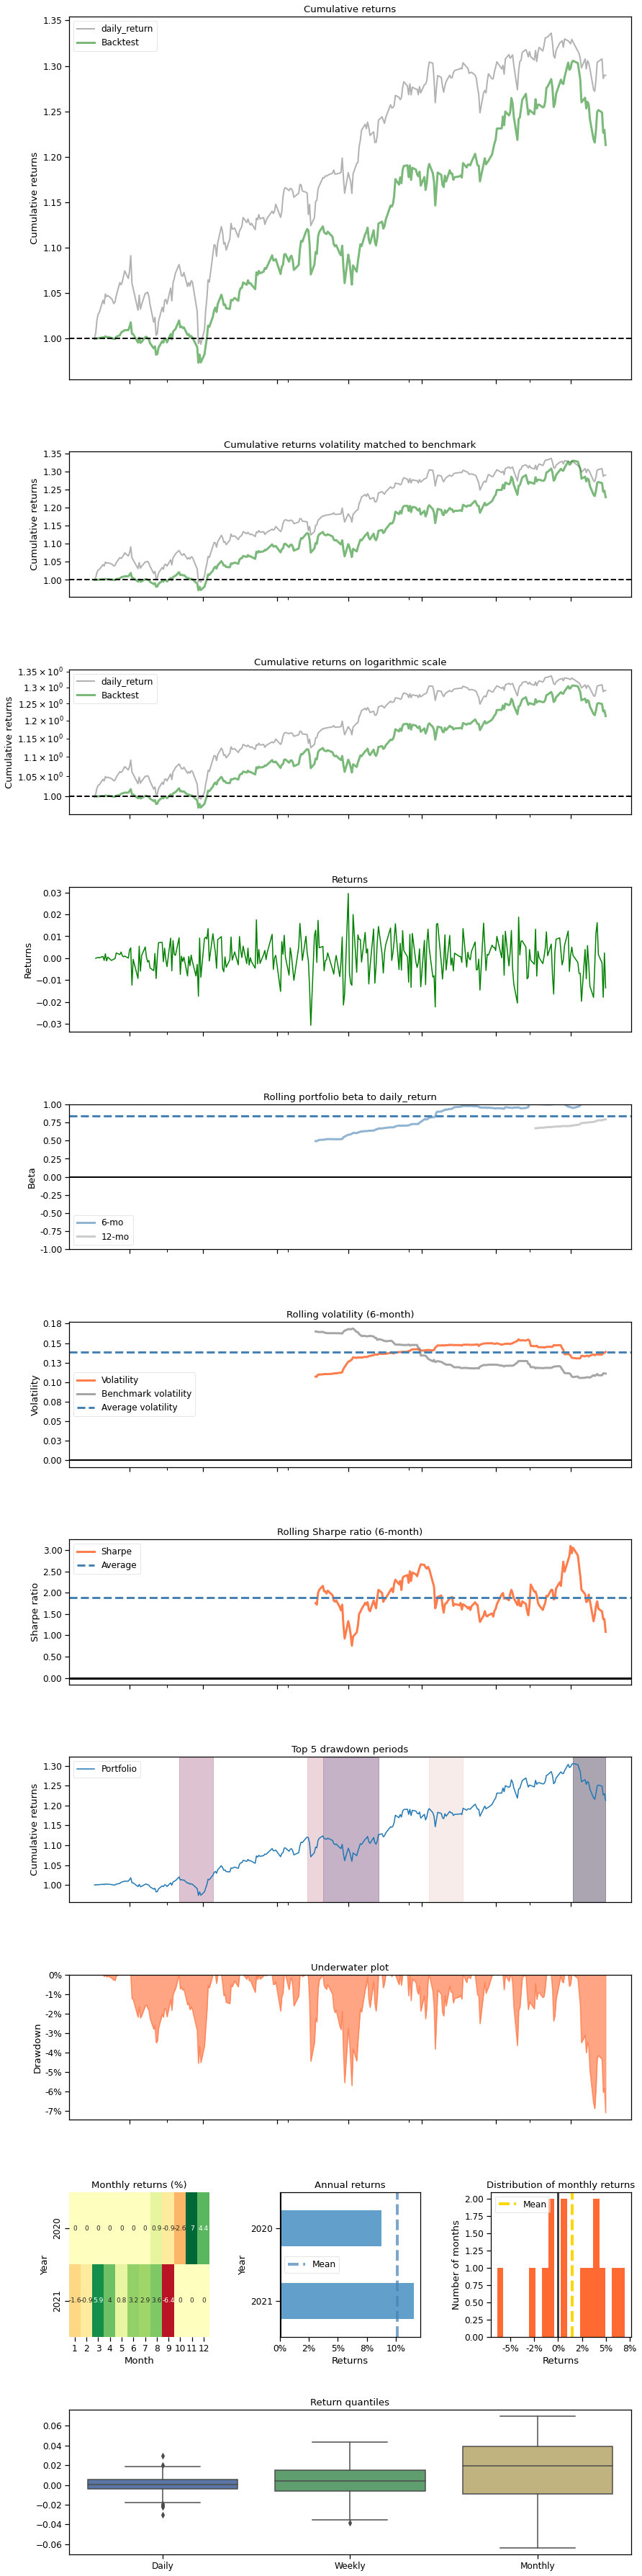

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_erl, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_erl.loc[0,'date'],
             baseline_end = account_value_erl.loc[len(account_value_erl)-1,'date'])

### 4.2 RLlib

In [ ]:
RLlib_PARAMS = {"lr": 5e-6,"train_batch_size": 1000,"gamma": 0.99}

#### Train

In [ ]:
#demo for rllib
ray.shutdown() #always shutdown previous session if any

train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='rllib', 
      env=env, 
      model_name='ppo', 
      cwd='./test_ppo',
      rllib_params = RLlib_PARAMS,
      total_episodes=30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

2021-10-19 15:32:25,344	INFO services.py:1252 -- View the Ray dashboard at http://127.0.0.1:8265
2021-10-19 15:32:28,609	WARNING ppo.py:149 -- `train_batch_size` (1000) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 500.
2021-10-19 15:32:48,389	WARNING trainer_template.py:186 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-10-19 15:32:48,399	INFO trainable.py:112 -- Trainable.setup took 19.795 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


#### Test

In [ ]:
ray.shutdown() #always shutdown previous session if any

account_value_rllib = test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = config.DOW_30_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST,
     drl_lib='rllib', 
     env=env, 
     model_name='ppo', 
     cwd='./test_ppo/checkpoint_000030/checkpoint-30',
     rllib_params = RLlib_PARAMS)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

2021-10-19 15:38:32,300	INFO services.py:1252 -- View the Ray dashboard at http://127.0.0.1:8265
2021-10-19 15:38:56,245	WARNING trainer_template.py:186 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2021-10-19 15:38:56,256	INFO trainable.py:112 -- Trainable.setup took 27.213 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2021-10-19 15:38:56,531	INFO trainable.py:394 -- Restored on 172.28.0.2 from checkpoint: ./test_ppo/checkpoint_000030/checkpoint-30
2021-10-19 15:38:56,548	INFO trainable.py:401 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 283.62257981300354, '_episodes_total': 18}


Restoring from checkpoint path ./test_ppo/checkpoint_000030/checkpoint-30
episode return: 1.2950385307811543
Test Finished!


In [ ]:
len(account_value_rllib)

295

#### Plot

In [ ]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (294, 9)
Annual return          0.226750
Cumulative returns     0.269255
Annual volatility      0.139601
Sharpe ratio           1.539212
Calmar ratio           2.538976
Stability              0.915926
Max drawdown          -0.089308
Omega ratio            1.294292
Sortino ratio          2.240389
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995019
Daily value at risk   -0.016735
dtype: float64


In [ ]:
len(baseline_df.date)

294

In [ ]:
account_value_rllib = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_rllib[0:len(account_value_rllib)-1]})

In [ ]:
perf_stats_all = backtest_stats(account_value=account_value_rllib)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.248213
Cumulative returns     0.295200
Annual volatility      0.168233
Sharpe ratio           1.406830
Calmar ratio           2.985163
Stability              0.870361
Max drawdown          -0.083149
Omega ratio            1.266914
Sortino ratio          2.075692
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.954953
Daily value at risk   -0.020256
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (293, 8)


Start date,2020-08-03
End date,2021-09-30
Total months,14
,Backtest
Annual return,24.821%
Cumulative returns,29.52%
Annual volatility,16.823%
Sharpe ratio,1.41
Calmar ratio,2.99
Stability,0.87
Max drawdown,-8.315%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.31,2020-10-12,2020-10-30,2020-11-09,21
1,6.83,2021-08-12,2021-09-20,NaT,NaN
2,6.42,2021-07-09,2021-07-19,2021-08-11,24
3,5.00,2021-03-15,2021-03-24,2021-05-07,40
4,4.73,2021-01-20,2021-01-29,2021-02-04,12


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


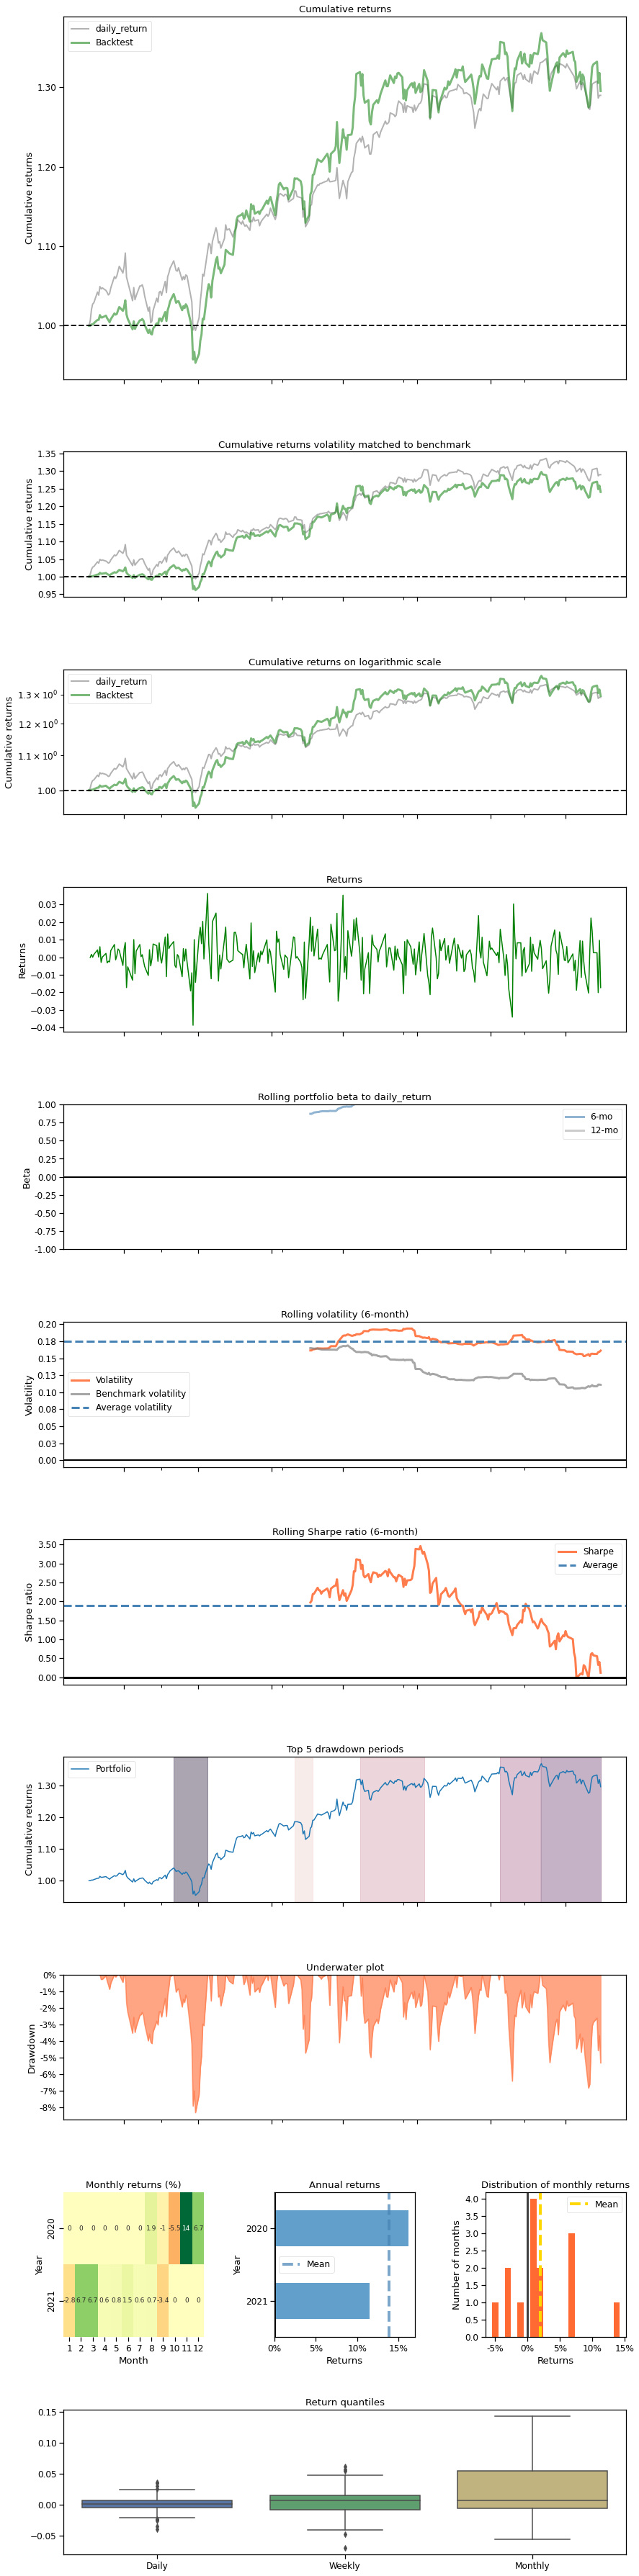

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_rllib, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_rllib.loc[0,'date'],
             baseline_end = account_value_rllib.loc[len(account_value_rllib)-1,'date'])

### 4.3 Stable-baselines3

In [ ]:
SAC_PARAMS = {"batch_size": 128,"buffer_size": 100000,"learning_rate": 0.0001,"learning_starts": 100,"ent_coef": "auto_0.1",}
PPO_PARAMS = {"n_steps": 2048,"ent_coef": 0.01,"learning_rate": 0.00025,"batch_size": 128}
TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 3e-5}

#### Train

In [ ]:
#demo for stable-baselines3
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = config.DOW_30_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='stable_baselines3', 
      env=env, 
      model_name='sac', 
      cwd='./test_sac',
      agent_params = SAC_PARAMS,
      total_timesteps=1e4)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

#### Test

In [ ]:
account_value_sb3=test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = config.DOW_30_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST, 
     drl_lib='stable_baselines3', 
     env=env, 
     model_name='sac', 
     cwd='./test_sac.zip')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
len(account_value_sb3)

295

#### Plot

In [ ]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (294, 9)
Annual return          0.226750
Cumulative returns     0.269255
Annual volatility      0.139601
Sharpe ratio           1.539212
Calmar ratio           2.538976
Stability              0.915926
Max drawdown          -0.089308
Omega ratio            1.294292
Sortino ratio          2.240389
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995019
Daily value at risk   -0.016735
dtype: float64


In [ ]:
account_value_sb3 = pd.DataFrame({'date':baseline_df.date,'account_value':account_value_sb3[0:len(account_value_sb3)-1]})

In [ ]:
perf_stats_all = backtest_stats(account_value=account_value_sb3)
perf_stats_all = pd.DataFrame(perf_stats_all)

Annual return          0.405739
Cumulative returns     0.487838
Annual volatility      0.185580
Sharpe ratio           1.934873
Calmar ratio           4.581519
Stability              0.916431
Max drawdown          -0.088560
Omega ratio            1.369857
Sortino ratio          3.060586
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.043790
Daily value at risk   -0.021956
dtype: float64


In [ ]:
account_value_sb3.tail()

,date,account_value
289,2021-09-24,1.534340e+06
290,2021-09-27,1.555200e+06
291,2021-09-28,1.528636e+06
292,2021-09-29,1.521086e+06
293,2021-09-30,1.487838e+06


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (293, 8)


Start date,2020-08-03
End date,2021-09-30
Total months,14
,Backtest
Annual return,40.574%
Cumulative returns,48.784%
Annual volatility,18.558%
Sharpe ratio,1.93
Calmar ratio,4.58
Stability,0.92
Max drawdown,-8.856%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.86,2020-10-12,2020-10-28,2020-11-09,21
1,8.10,2020-09-02,2020-09-23,2020-10-12,29
2,8.04,2021-06-04,2021-06-18,2021-08-10,48
3,7.24,2021-08-11,2021-09-20,NaT,NaN
4,6.44,2021-01-12,2021-01-27,2021-02-08,20


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


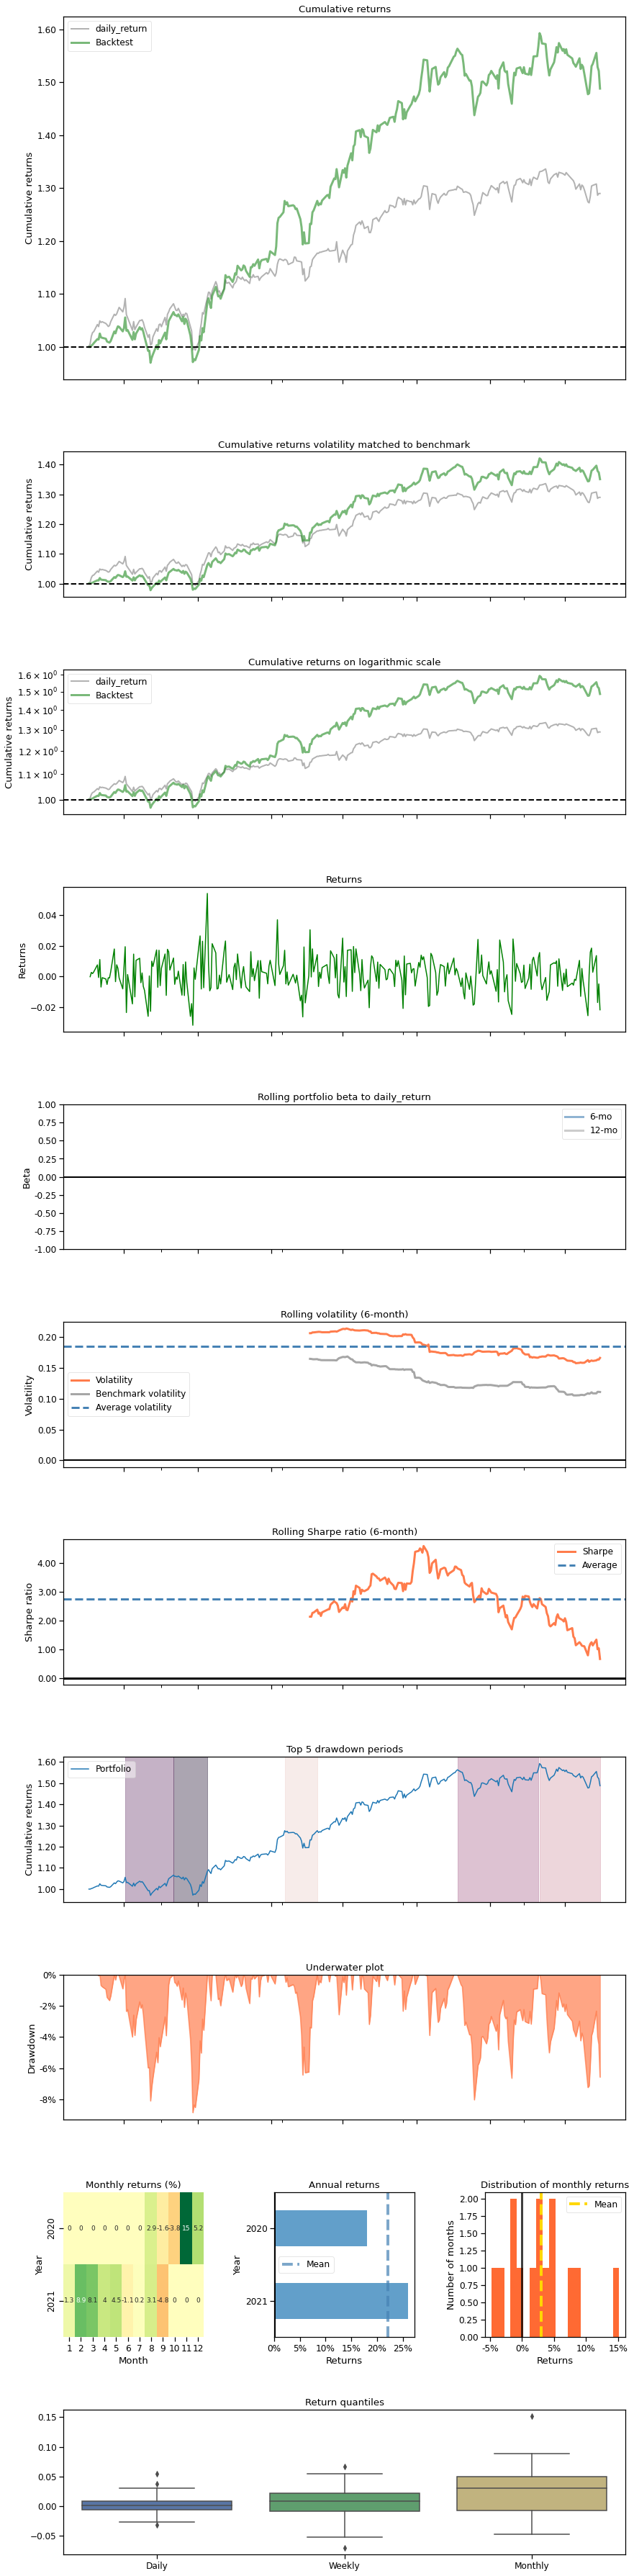

In [ ]:
print("==============Compare to DJIA===========")
#%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_sb3, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_sb3.loc[0,'date'],
             baseline_end = account_value_sb3.loc[len(account_value_sb3)-1,'date'])

## Part 5: Use Plotly to compare eRL, RLlib and SB3

In [ ]:
baseline_df

,date,open,high,low,close,adjcp,volume,tic,day
0,2020-08-03,26542.320312,26707.259766,26534.380859,26664.400391,26664.400391,439380000,^DJI,0
1,2020-08-04,26664.609375,26832.720703,26597.820312,26828.470703,26828.470703,346350000,^DJI,1
2,2020-08-05,26924.779297,27221.669922,26924.779297,27201.519531,27201.519531,366000000,^DJI,2
3,2020-08-06,27170.820312,27394.099609,27145.250000,27386.980469,27386.980469,322460000,^DJI,3
4,2020-08-07,27321.679688,27456.240234,27223.550781,27433.480469,27433.480469,321170000,^DJI,4
...,...,...,...,...,...,...,...,...,...
289,2021-09-24,34762.308594,34857.058594,34648.078125,34798.000000,34798.000000,254310000,^DJI,4
290,2021-09-27,34739.269531,35061.121094,34739.269531,34869.371094,34869.371094,289480000,^DJI,0
291,2021-09-28,34747.699219,34798.210938,34254.648438,34299.988281,34299.988281,379020000,^DJI,1
292,2021-09-29,34360.078125,34580.421875,34305.960938,34390.718750,34390.718750,290350000,^DJI,2


In [ ]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [ ]:
daily_return = account_value_sb3.copy()
daily_return['sb3_return'] = account_value_sb3.account_value.pct_change()
daily_return['erl_return'] = account_value_erl.account_value.pct_change()
daily_return['rllib_return'] = account_value_rllib.account_value.pct_change()
daily_return['djia_return'] = baseline_df.adjcp.pct_change()


In [ ]:
daily_return.head()

,date,account_value,sb3_return,erl_return,rllib_return,djia_return
0,2020-08-03,1.000000e+06,NaN,NaN,NaN,NaN
1,2020-08-04,9.998531e+05,-0.000147,-0.000015,-0.000194,0.006153
2,2020-08-05,1.002289e+06,0.002437,0.000113,0.003239,0.013905
3,2020-08-06,1.004240e+06,0.001947,0.000144,0.001245,0.006818
4,2020-08-07,1.003796e+06,-0.000442,0.000204,0.001415,0.001698


In [ ]:
daily_return.to_csv('daily_return_erl_sb3_rllib.csv',index=False)
#daily_return = pd.read_csv('daily_return_erl_sb3_rllib.csv')

In [ ]:
rllib_cumpod =(daily_return.rllib_return+1).cumprod()-1
sb3_cumpod =(daily_return.sb3_return+1).cumprod()-1
erl_cumpod =(daily_return.erl_return+1).cumprod()-1
dji_cumpod =(daily_return.djia_return+1).cumprod()-1

In [ ]:
time_ind = pd.Series(daily_return.date)

In [ ]:
trace0_portfolio = go.Scatter(x = time_ind, y = rllib_cumpod, mode = 'lines', name = 'RLlib')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = sb3_cumpod, mode = 'lines', name = 'Stablebaselines3')
trace3_portfolio = go.Scatter(x = time_ind, y = erl_cumpod, mode = 'lines', name = 'ElegantRL')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [ ]:
fig = go.Figure()
fig.add_trace(trace3_portfolio)
fig.add_trace(trace2_portfolio)

fig.add_trace(trace0_portfolio)
fig.add_trace(trace1_portfolio)




fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *70}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()